In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('data/train_labels.csv', index_col=0)
test_data = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5987820 entries, 0 to 5987819
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [3]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

In [4]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [5]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


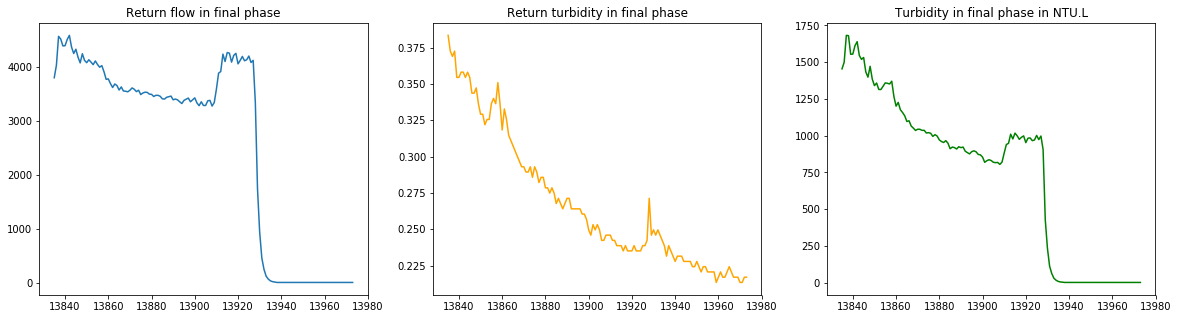

In [6]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

# Попробуем посмотреть на данные. Возможно, получится увидеть некоторые закономерности

In [7]:
import time
import csv
import pickle
import random
import time
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from functools import wraps
from matplotlib.font_manager import FontProperties
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline
pd.options.display.max_columns = None # выводить в датафрейме всё
%pylab inline
figsize(10, 3)


Populating the interactive namespace from numpy and matplotlib


In [8]:
train_data_ts = train_data.copy()
train_data_ts.index = train_data_ts['timestamp']

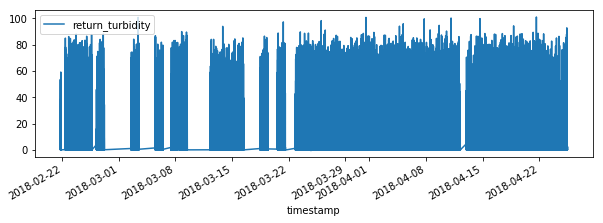

In [9]:
train_data_ts[['return_turbidity']].plot()

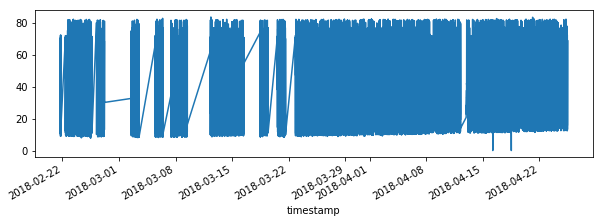

In [10]:
train_data_ts[train_data_ts['phase'] == 'final_rinse']['return_temperature'].plot()

In [11]:
train_data = train_data[train_data['phase'] != 'final_rinse']

In [12]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [13]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

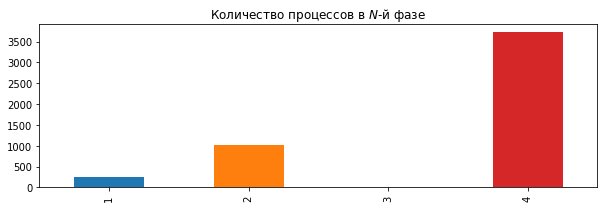

In [14]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

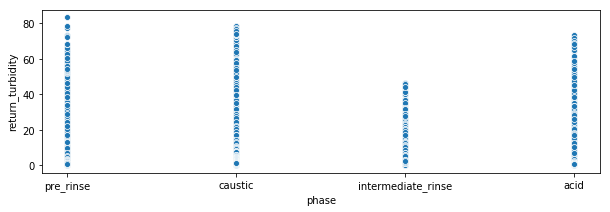

In [15]:
sns.scatterplot(train_data['phase'].head(100000), train_data['return_turbidity'].head(100000))

In [16]:
train_data

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,15776.9100,True,True,False,False,False,False,False,False,True,True,55.499672,41.555992,44.026875,49.474102,32.385708,83.036750,73.032410,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,13241.4640,True,True,False,False,False,False,False,False,True,True,55.487920,41.624170,44.045685,49.457645,32.385708,83.015045,73.032410,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,10698.7850,True,True,False,False,False,False,False,False,True,True,55.476166,41.638275,44.045685,49.462350,32.385708,83.015045,73.032410,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,8007.8125,True,True,False,False,False,False,False,False,True,True,55.471466,41.647675,44.048030,49.462350,32.385708,83.036750,73.032410,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,6004.0510,True,True,False,False,False,False,False,False,True,True,55.459705,41.654730,44.048030,49.462350,32.385708,83.015045,73.032410,45.398197,44.334373,False,0.0,False,0.0,False
5,20001,405,pre_rinse,2018-04-15 04:20:57,L4,18710.215,0.944444,18.583622,0.509684,0.166377,4918.9814,True,True,False,False,False,False,False,False,True,True,55.445602,41.647675,44.048030,49.462350,32.385708,82.993350,73.032410,45.385914,44.336000,False,0.0,False,0.0,False
6,20001,405,pre_rinse,2018-04-15 04:20:59,L4,21216.725,1.032118,18.460648,0.443773,0.292969,6188.5127,True,True,False,False,False,False,False,False,True,True,55.436195,41.628872,44.048030,49.462350,32.385708,82.993350,73.032410,45.369984,44.332523,False,0.0,False,0.0,False
7,20001,405,pre_rinse,2018-04-15 04:21:01,L4,22403.066,1.087891,18.420862,0.521089,0.271267,7606.3364,True,True,False,False,False,False,False,False,True,True,55.422090,41.603010,44.052734,49.462350,32.367622,82.953560,73.032410,45.381107,44.336490,False,0.0,False,0.0,False
8,20001,405,pre_rinse,2018-04-15 04:21:03,L4,23278.357,1.140842,18.420862,0.779835,0.361690,8586.5170,True,True,False,False,False,False,False,False,True,True,55.407990,41.565395,44.052734,49.462350,32.367622,82.953560,73.032410,45.402290,44.334263,False,0.0,False,0.0,False


### Создадим уникальный индентификатор фазы для каждого процесса:


In [17]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 85% of phases to keep
rng = np.random.RandomState(13)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.85),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

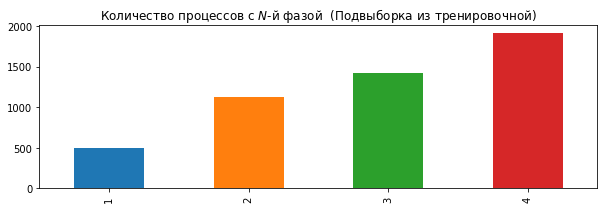

In [18]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

### Feature engineering

In [19]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000)).index.nunique()

6

In [20]:
#train_limited_with_phases_gr = train_limited.head(15).copy()
#phases = ['acid', 'caustic', 'pre_rinse']
#cols = train_limited_with_phases_gr.columns
#for col in cols[3:]:
#    for process in train_limited_with_phases_gr['process_id'].unique():
#        for phase in phases:
#            train_limited_with_phases_gr[col + '_' + phase] = train_limited[col][(train_limited['process_id'] == process) & (train_limited['phase'] == phase)]

In [21]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

## Преобразуем признаки временного ряда

In [90]:
import scipy as sc
def tail60mean(x):
    return x.tail(60).mean()

def tail60std(x):
    return x.tail(60).std()

def tail60median(x):
    return x.tail(60).median()



def log_agg(x):
    return np.log(abs(x.tail(1)) + 0.1)




def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns

    ts_df = df[ts_cols].set_index('process_id')
    # create features: min, max, mean, standard deviation, and mean of the last 50 observations
    ts_features = ts_df.groupby('process_id').aggregate(['min', 'max', 'mean', 'std',
                                                             tail60mean,
                                                             tail60std,
                                                             log_agg,
                                                             cox_box,
                                                        'sum', 'mad'])
    
    return ts_features

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

supply_flow                                                        \
                    min         max          mean           std    tail60mean   
process_id                                                                      
20001         47.019676   59396.703  50103.211842  11397.417702  54375.964583   
20002          7.233796   34295.430  27142.963425   8337.197885  29972.692233   
20003      -1244.213000  103096.070  30455.285348  10152.968335  33415.738300   
20004        -43.402780   48394.098  31099.263353  13132.729350  36851.129117   
20005          0.000000   31295.209  28241.716353   7107.794924  30875.832233   
20008       2723.524400   53461.370  29302.278623   9031.206946  32772.593667   

                                                                             \
              tail60std    log_agg       cox_box           sum          mad   
process_id                                                                    
20001       4268.329697  10.100100  4.808407e+05  6.814037e+07  7947.648538   
20002        249.084111  10.243775  5.823625e+05  1.210576e+07  5058.926236   
20003       3147.886174  10.321726  6.461452e+05  6.447384e+07  6782.761736   
20004       5135.883456  10.416917  7.335828e+05  2.301345e+07  9033.103545   
20005         74.541398  10.351223  6.720633e+05  7.173396e+06  4309.652939   
20008       7007.313406  10.886716  1.372407e+06  2.432089e+06  5111.618406   

           supply_pressure                                                     \
                       min       max      mean       std tail60mean tail60std   
process_id                                                                      
20001            -0.036024  2.223741  1.693400  0.290767   1.696517  0.264640   
20002            -0.034071  2.170790  1.477925  0.421852   1.594419  0.031594   
20003            -0.033854  3.859375  2.687741  0.858450   2.968157  0.088533   
20004            -0.009549  0.471137  0.281616  0.161467   0.321799  0.120545   
20005            -0.023438  0.487196  0.418469  0.128794   0.466699  0.001947   
20008             0.174479  0.174913  0.174733  0.000111   0.174678  0.000060   

                                                      return_temperature  \
             log_agg   cox_box          sum       mad                min   
process_id                                                                 
20001      -1.996518  0.964354  2303.023875  0.134970          13.888889   
20002       0.374582  2.546399   659.154517  0.233771           8.742043   
20003       1.159291  4.944359  5689.948363  0.533843          11.024305   
20004      -0.656584  1.439169   208.395834  0.147526          28.757957   
20005      -0.551048  1.502739   106.291016  0.080627          17.986834   
20008      -1.292090  1.178406    14.502821  0.000083          10.481771   

                                                                            \
                  max       mean        std tail60mean tail60std   log_agg   
process_id                                                                   
20001       82.530380  65.577520  22.264019  72.535265  0.044995  4.284227   
20002       76.392510  53.616841  22.887856  75.573942  0.538294  4.337193   
20003       81.586370  60.850462  22.457923  71.469483  0.021816  4.270826   
20004       82.490590  70.845547  15.281445  71.713445  0.148274  4.272341   
20005       71.520546  58.049278  19.047244  71.058545  0.137635  4.263676   
20008       30.240885  20.152616   7.770991  22.722138  7.699782  3.412496   

                                                 return_conductivity  \
               cox_box            sum        mad                 min   
process_id                                                             
20001       210.862010   89185.427283  18.956638            0.255486   
20002       226.031487   23913.111281  19.047595            0.172301   
20003       207.190074  128820.428049  20.322458            0.205189   
20004       207.6018

In [91]:
def create_feature_matrix(df):
    metadata = prep_metadata(df)
    time_series = prep_time_series_features(df)
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    return feature_matrix

In [92]:
train_features = create_feature_matrix(train_limited)


In [93]:
train_features.head(1000)

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,num_phases,"(supply_flow, min)","(supply_flow, max)","(supply_flow, mean)","(supply_flow, std)","(supply_flow, tail60mean)","(supply_flow, tail60std)","(supply_flow, log_agg)","(supply_flow, cox_box)","(supply_flow, sum)","(supply_flow, mad)","(supply_pressure, min)","(supply_pressure, max)","(supply_pressure, mean)","(supply_pressure, std)","(supply_pressure, tail60mean)","(supply_pressure, tail60std)","(supply_pressure, log_agg)","(supply_pressure, cox_box)","(supply_pressure, sum)","(supply_pressure, mad)","(return_temperature, min)","(return_temperature, max)","(return_temperature, mean)","(return_temperature, std)","(return_temperature, tail60mean)","(return_temperature, tail60std)","(return_temperature, log_agg)","(return_temperature, cox_box)","(return_temperature, sum)","(return_temperature, mad)","(return_conductivity, min)","(return_conductivity, max)","(return_conductivity, mean)","(return_conductivity, std)","(return_conductivity, tail60mean)","(return_conductivity, tail60std)","(return_conductivity, log_agg)","(return_conductivity, cox_box)","(return_conductivity, sum)","(return_conductivity, mad)","(return_turbidity, min)","(return_turbidity, max)","(return_turbidity, mean)","(return_turbidity, std)","(return_turbidity, tail60mean)","(return_turbidity, tail60std)","(return_turbidity, log_agg)","(return_turbidity, cox_box)","(return_turbidity, sum)","(return_turbidity, mad)","(return_flow, min)","(return_flow, max)","(return_flow, mean)","(return_flow, std)","(return_flow, tail60mean)","(return_flow, tail60std)","(return_flow, log_agg)","(return_flow, cox_box)","(return_flow, sum)","(return_flow, mad)","(tank_level_pre_rinse, min)","(tank_level_pre_rinse, max)","(tank_level_pre_rinse, mean)","(tank_level_pre_rinse, std)","(tank_level_pre_rinse, tail60mean)","(tank_level_pre_rinse, tail60std)","(tank_level_pre_rinse, log_agg)","(tank_level_pre_rinse, cox_box)","(tank_level_pre_rinse, sum)","(tank_level_pre_rinse, mad)","(tank_level_caustic, min)","(tank_level_caustic, max)","(tank_level_caustic, mean)","(tank_level_caustic, std)","(tank_level_caustic, tail60mean)","(tank_level_caustic, tail60std)","(tank_level_caustic, log_agg)","(tank_level_caustic, cox_box)","(tank_level_caustic, sum)","(tank_level_caustic, mad)","(tank_level_acid, min)","(tank_level_acid, max)","(tank_level_acid, mean)","(tank_level_acid, std)","(tank_level_acid, tail60mean)","(tank_level_acid, tail60std)","(tank_level_acid, log_agg)","(tank_level_acid, cox_box)","(tank_level_acid, sum)","(tank_level_acid, mad)","(tank_level_clean_water, min)","(tank_level_clean_water, max)","(tank_level_clean_water, mean)","(tank_level_clean_water, std)","(tank_level_clean_water, tail60mean)","(tank_level_clean_water, tail60std)","(tank_level_clean_water, log_agg)","(tank_level_clean_water, cox_box)","(tank_level_clean_water, sum)","(tank_level_clean_water, mad)","(tank_temperature_pre_rinse, min)","(tank_temperature_pre_rinse, max)","(tank_temperature_pre_rinse, mean)","(tank_temperature_pre_rinse, std)","(tank_temperature_pre_rinse, tail60mean)","(tank_temperature_pre_rinse, tail60std)","(tank_temperature_pre_rinse, log_agg)","(tank_temperature_pre_rinse, cox_box)","(tank_temperature_pre_rinse, sum)","(tank_temperature_pre_rinse, mad)","(tank_temperature_caustic, min)","(tank_temperature_caustic, max)","(tank_temperature_caustic, mean)","(tank_temperature_caustic, std)","(tank_temperature_caustic, tail60mean)","(tank_temperature_caustic, tail60std)","(tank_temperature_caustic, log_agg)","(tank_temperature_caustic, cox_box)","(tank_temperature_caustic, sum)","(tank_temperature_caustic, mad)","(tank_temperature_acid, min)","(tank_temperature_acid, max)","(tank_temperature_acid, mean)","(tank_temperature_acid, std)","(tank_temperature_acid, tail60mean)","(tank_temperature_acid, tail60std)","(tank_temperature_acid, log_agg)","(ta

# Строим модели и тестируем их:

**Напишем функцию, которая считает ошибку предсказания. Для того, чтобы её можно было использовать вместе с sklearn воспользуемся sklearn.metrics.make_scorer:**

In [26]:
def mean_abs_percentage_err(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))

from sklearn.metrics import make_scorer
mape_modified_scorer = make_scorer(mean_abs_percentage_err, greater_is_better=False)
    

## Напишем функцию, которая тестирует модели на кросс-валидации и отложенной выборке

In [27]:
from sklearn.model_selection import cross_val_score
def models_validation(X, y, models, folds):
    tsCV = TimeSeriesSplit(5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 13)
    i = 0
    for model in models:
        i = i + 1
        model.fit(X_train, y_train)
        print(i, 'model cross-val:', np.mean(cross_val_score(model, X, y, scoring=mape_modified_scorer, n_jobs=-1)))
        print(i, 'model on hold data:', mean_abs_percentage_err(model.predict(X_test), y_test))
        print('\n')
    return 0

## Воспользуемся TimeSeriesSplit для проведения кросс-валидации для временных рядом и GridSearchCV, чтобы найти оптимальные параметры для 

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=13, n_jobs=-1, max_leaf_nodes=165, 
                                     min_samples_leaf=8, min_samples_split=0.005
#                                     max_depth=23,
#                                    max_leaf_nodes= 100,
#                                     min_samples_leaf = 5,
                                     
      
                                    #max_features=17,
                                   # criterion = 'mse',
                                  
                                    )
rf_param_grid =  {
                  'n_estimators' : [50],
                  'random_state' : [13], 
                  #'n_jobs=-1' : [-1],
                  'max_depth' : [35],
                  'max_features' : [40, 50, 80],
                  'min_weight_fraction_leaf' : [0.5, 0.1, 0.01, 0.0001,  0.00001],
                  'min_impurity_decrease' : [0.00001, 0.001, 0.01, 0.1, 1],
                  'min_impurity_split' : [0.00001, 0.001, 0.01, 0.1, 0.5]
                 # 'min_samples_leaf' : list(np.arange(2, 13)) + [20, 25, 50],
                 # 'max_leaf_nodes' : list(np.arange(2, 13)) + [20, 25, 50]
                                        }                 
rf_grid = GridSearchCV(estimator=rf_regressor, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=rf_param_grid)

#sgd_regr = SGDRegressor(penalty='elasticnet', penalty='l1')

In [78]:
#rf_grid.fit(X_train, y_train)
train_features_xgb = train_features.copy()
for col_name in train_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "")
    new_col_name = str(new_col_name).replace("<", "")
    new_col_name = str(new_col_name).replace(",", "")
    new_col_name = str(new_col_name).replace("[", "")
    new_col_name = str(new_col_name).replace("]", "")
    train_features_xgb[new_col_name] = train_features_xgb[col_name]
    train_features_xgb.pop(col_name)

## Оптимальные параметры и лучший результат rf:

In [72]:
#rf_grid.best_params_, rf_grid.best_score_
#({'max_depth': 20,
#  'max_features': 40,
#  'min_samples_leaf': 5,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6180501020995538)
#{'max_depth': 20,
#  'max_features': 50,
#  'max_leaf_nodes': 50,
#  'min_samples_leaf': 3,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6628379946829989

rf_after_grid = RandomForestRegressor(n_estimators=25, max_depth=35, #max_features=100, 
                                      min_samples_leaf=8, max_leaf_nodes = 200, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      bootstrap=False,
                                      random_state=13)
rf_after_grid.fit(X_train, y_train)
#rf_grid.best_params_, rf_grid.best_score_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

## Воспользуемся RFE для того, чтобы отобрать важные признаки:

In [73]:
from sklearn.svm import SVR
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha =  0.9, random_state=13, max_iter = 1000, tol = 0.0000001)
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_data_scaled = train_features.copy()
train_data_scaled = minmax.fit_transform(train_data_scaled)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(train_data_scaled, np.ravel(train_labels),
                                                                 train_size=0.7, random_state=13)


In [74]:
from sklearn.feature_selection import RFECV, SelectKBest
rfecv = RFECV(estimator=ridge, step = 1, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(5))


In [75]:
rfecv.fit(X_train_scaled, y_train)

RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
   estimator=Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=13, solver='auto', tol=1e-07),
   min_features_to_select=1, n_jobs=-1,
   scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
   step=1, verbose=0)

In [77]:
mean_abs_percentage_err(rfecv.predict(X_test_scaled), y_test) - 0.9170895496280376
#2.1592417953441427

2.023935372960959

In [79]:
models_validation(train_features, np.ravel(train_labels), [rf_after_grid], folds=5)

1 model cross-val: -1.9127329534970643
1 model on hold data: 3.2777341037104026




0

In [62]:
from sklearn.feature_selection import SelectPercentile
kbest = SelectPercentile(score_func=mape_modified_scorer)
kbest.fit(X=X_train, y=y_train)

TypeError: __call__() missing 1 required positional argument: 'y_true'

## Добавим Knn и проверим эту модель на шкалированных данных

In [45]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7, p = 2)
extra_trees = ExtraTreesRegressor( n_estimators=200, max_depth=45, #max_features=100, 
                                      min_samples_leaf=5, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      random_state=13)
bagging = BaggingRegressor(max_samples=0.85, n_estimators=10, )
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
rdg = Ridge()
lss = Lasso()
els = ElasticNet(copy_X=True)
rfecv = RFECV(estimator=extra_trees, step = 15, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(3))

In [46]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn, extra_trees, bagging, svr, rdg, lss, els], folds=5)

1 model cross-val: -1.2984858868075166
1 model on hold data: 3.1987743411088436


2 model cross-val: -1.0117036757498852
2 model on hold data: 3.04791758717017


3 model cross-val: -1.4379192969409227
3 model on hold data: 3.641191493764286


4 model cross-val: -2.4116018918505695
4 model on hold data: 0.9877977571959007


5 model cross-val: -1.2804308053712246
5 model on hold data: 3.330082066343979


6 model cross-val: -1.4474951438249117
6 model on hold data: 3.9409472102732113


7 model cross-val: -0.9970132470919354
7 model on hold data: 2.9015466184422363




0

## Результат сравним с RandomForest! Настроим knn:

In [152]:
knn_grid_params = {'n_neighbors' : list(np.arange(2, 10)) + [ 40, 41, 42, 43, 44, 45, 46, 47 ],
                  'leaf_size' : list(np.arange(2, 10) + [15, 20, 25, 30, 50, 70, 90, 110])}
knn_grid = GridSearchCV(estimator=knn, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=knn_grid_params)

In [262]:
knn_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47], 'leaf_size': [17, 23, 29, 35, 56, 77, 98, 119]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=2)

In [196]:
knn_grid.best_params_, knn_grid.best_score_

NameError: name 'knn_grid' is not defined

In [47]:
knn_after_grid = KNeighborsRegressor(metric='braycurtis',n_neighbors=44, p=2, weights='distance')
knn_bagging = BaggingRegressor(base_estimator=knn_after_grid, max_samples=0.9, max_features=0.8, n_jobs=-1,
                              n_estimators=30)

In [48]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn_after_grid], 5)

1 model cross-val: -1.0855751026543954
1 model on hold data: 2.859974779720699




0

In [67]:
knn_after_grid.fit(train_data_scaled, np.ravel(train_labels))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=44, p=3,
          weights='distance')

## Попробуем использовать

In [48]:
rf_after_grid.fit(train_data_scaled, np.ravel(train_labels))

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [41]:
test_features = create_feature_matrix(test_data)


In [42]:
test_features = minmax.transform(test_features)

In [49]:
preds = rf_after_grid.predict(test_features)

In [50]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [51]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [52]:
my_submission.to_csv('./submissions/7th_try_to_beat_benchmark_2.csv')

In [79]:
mape_modified_scorer(rf_after_grid, X_test, y_test), mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test)

(-0.549157172260939, 0.9148239861830831)

## NEURAL NET

In [41]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_features_scaled = train_features.copy()
train_features_scaled = minmax.fit_transform(train_features_scaled)

mlp = MLPRegressor(solver='lbfgs', random_state=13, hidden_layer_sizes=50, batch_size=1000,
                  )


In [106]:
from catboost import CatBoostRegressor
catboost1 = CatBoostRegressor(custom_metric='MAPE', max_depth=4)

In [107]:
models_validation(train_features_scaled, np.ravel(train_labels), [catboost1], 5)

Got unsafe target value = 1.47214e+06 at object #0 of dataset learn


0:	learn: 6471898.1166481	total: 17.8ms	remaining: 17.8s
1:	learn: 6416466.2080386	total: 32.3ms	remaining: 16.1s
2:	learn: 6350296.2280561	total: 46.3ms	remaining: 15.4s
3:	learn: 6291219.6778300	total: 60.3ms	remaining: 15s
4:	learn: 6227195.4834407	total: 75.1ms	remaining: 14.9s
5:	learn: 6161423.3832398	total: 88.7ms	remaining: 14.7s
6:	learn: 6142457.2134678	total: 103ms	remaining: 14.6s
7:	learn: 6087614.7319736	total: 117ms	remaining: 14.5s
8:	learn: 6054983.8320197	total: 131ms	remaining: 14.4s
9:	learn: 6012450.7360934	total: 145ms	remaining: 14.4s
10:	learn: 5959725.7127560	total: 160ms	remaining: 14.3s
11:	learn: 5906497.9307335	total: 173ms	remaining: 14.3s
12:	learn: 5857627.5943035	total: 187ms	remaining: 14.2s
13:	learn: 5816106.7441467	total: 206ms	remaining: 14.5s
14:	learn: 5794303.5053110	total: 225ms	remaining: 14.8s
15:	learn: 5778680.1277510	total: 248ms	remaining: 15.3s
16:	learn: 5743003.5228834	total: 269ms	remaining: 15.6s
17:	learn: 5707876.3883200	total: 288

157:	learn: 4157533.2009367	total: 2.83s	remaining: 15.1s
158:	learn: 4149591.0557190	total: 2.85s	remaining: 15.1s
159:	learn: 4140427.7244359	total: 2.87s	remaining: 15.1s
160:	learn: 4134450.7402289	total: 2.89s	remaining: 15s
161:	learn: 4126417.2971899	total: 2.9s	remaining: 15s
162:	learn: 4120179.2441790	total: 2.92s	remaining: 15s
163:	learn: 4116923.6638261	total: 2.95s	remaining: 15s
164:	learn: 4114748.0503985	total: 2.97s	remaining: 15s
165:	learn: 4112236.7633760	total: 2.99s	remaining: 15s
166:	learn: 4107601.6600732	total: 3.02s	remaining: 15.1s
167:	learn: 4101500.6883800	total: 3.04s	remaining: 15.1s
168:	learn: 4093861.9713493	total: 3.07s	remaining: 15.1s
169:	learn: 4091451.6156821	total: 3.09s	remaining: 15.1s
170:	learn: 4086005.0363529	total: 3.12s	remaining: 15.1s
171:	learn: 4085337.8881756	total: 3.15s	remaining: 15.2s
172:	learn: 4082836.2263199	total: 3.17s	remaining: 15.2s
173:	learn: 4080487.7431489	total: 3.2s	remaining: 15.2s
174:	learn: 4078473.4582345	

309:	learn: 3618867.8792323	total: 5.71s	remaining: 12.7s
310:	learn: 3616146.7419363	total: 5.76s	remaining: 12.8s
311:	learn: 3614827.0983572	total: 5.79s	remaining: 12.8s
312:	learn: 3612948.1440132	total: 5.82s	remaining: 12.8s
313:	learn: 3611882.6197240	total: 5.84s	remaining: 12.8s
314:	learn: 3610033.5961717	total: 5.86s	remaining: 12.7s
315:	learn: 3608757.7317565	total: 5.88s	remaining: 12.7s
316:	learn: 3606089.9478765	total: 5.9s	remaining: 12.7s
317:	learn: 3605551.5757439	total: 5.91s	remaining: 12.7s
318:	learn: 3603042.6286320	total: 5.93s	remaining: 12.7s
319:	learn: 3603013.9297980	total: 5.95s	remaining: 12.7s
320:	learn: 3598968.5458346	total: 5.97s	remaining: 12.6s
321:	learn: 3597430.6515672	total: 6s	remaining: 12.6s
322:	learn: 3596435.9727438	total: 6.01s	remaining: 12.6s
323:	learn: 3592950.5060883	total: 6.04s	remaining: 12.6s
324:	learn: 3589458.8685091	total: 6.05s	remaining: 12.6s
325:	learn: 3587452.0021404	total: 6.07s	remaining: 12.5s
326:	learn: 358543

463:	learn: 3270633.3610815	total: 8.44s	remaining: 9.75s
464:	learn: 3270164.2011678	total: 8.46s	remaining: 9.74s
465:	learn: 3269574.8721308	total: 8.49s	remaining: 9.72s
466:	learn: 3268425.8258725	total: 8.5s	remaining: 9.7s
467:	learn: 3258380.2336907	total: 8.52s	remaining: 9.68s
468:	learn: 3257015.8997470	total: 8.53s	remaining: 9.66s
469:	learn: 3256587.8353255	total: 8.55s	remaining: 9.64s
470:	learn: 3256421.5383527	total: 8.56s	remaining: 9.62s
471:	learn: 3255798.9470892	total: 8.58s	remaining: 9.6s
472:	learn: 3254179.2753389	total: 8.6s	remaining: 9.59s
473:	learn: 3252940.6525982	total: 8.64s	remaining: 9.58s
474:	learn: 3251126.0552252	total: 8.67s	remaining: 9.59s
475:	learn: 3250080.0623784	total: 8.71s	remaining: 9.58s
476:	learn: 3248842.8167697	total: 8.73s	remaining: 9.57s
477:	learn: 3248688.7031783	total: 8.75s	remaining: 9.56s
478:	learn: 3247052.8942742	total: 8.79s	remaining: 9.56s
479:	learn: 3244751.8232173	total: 8.81s	remaining: 9.54s
480:	learn: 324285

607:	learn: 3068397.9027840	total: 11s	remaining: 7.09s
608:	learn: 3068382.6222898	total: 11s	remaining: 7.08s
609:	learn: 3067218.5842825	total: 11s	remaining: 7.06s
610:	learn: 3067007.2026968	total: 11.1s	remaining: 7.04s
611:	learn: 3064993.9254975	total: 11.1s	remaining: 7.03s
612:	learn: 3064591.5586349	total: 11.1s	remaining: 7.01s
613:	learn: 3060521.3148421	total: 11.1s	remaining: 6.99s
614:	learn: 3059636.1807682	total: 11.1s	remaining: 6.97s
615:	learn: 3059342.5154614	total: 11.1s	remaining: 6.95s
616:	learn: 3058508.8831743	total: 11.2s	remaining: 6.92s
617:	learn: 3057255.3816342	total: 11.2s	remaining: 6.9s
618:	learn: 3057062.6044824	total: 11.2s	remaining: 6.88s
619:	learn: 3056209.5746025	total: 11.2s	remaining: 6.86s
620:	learn: 3056029.9191085	total: 11.2s	remaining: 6.85s
621:	learn: 3055824.1165386	total: 11.2s	remaining: 6.83s
622:	learn: 3054513.0104620	total: 11.3s	remaining: 6.81s
623:	learn: 3053937.5282077	total: 11.3s	remaining: 6.79s
624:	learn: 3052495.3

756:	learn: 2929962.8136398	total: 13.5s	remaining: 4.33s
757:	learn: 2929007.1351693	total: 13.5s	remaining: 4.31s
758:	learn: 2928966.7942165	total: 13.5s	remaining: 4.3s
759:	learn: 2924908.0428101	total: 13.5s	remaining: 4.28s
760:	learn: 2922898.6248092	total: 13.6s	remaining: 4.26s
761:	learn: 2922891.4440713	total: 13.6s	remaining: 4.24s
762:	learn: 2922368.9394958	total: 13.6s	remaining: 4.22s
763:	learn: 2922358.8394939	total: 13.6s	remaining: 4.2s
764:	learn: 2921699.6890187	total: 13.6s	remaining: 4.18s
765:	learn: 2921693.1942932	total: 13.6s	remaining: 4.16s
766:	learn: 2921635.1031540	total: 13.6s	remaining: 4.14s
767:	learn: 2921116.1285772	total: 13.6s	remaining: 4.12s
768:	learn: 2921015.2600259	total: 13.7s	remaining: 4.1s
769:	learn: 2920880.9783117	total: 13.7s	remaining: 4.08s
770:	learn: 2920747.2358741	total: 13.7s	remaining: 4.07s
771:	learn: 2917689.1813869	total: 13.7s	remaining: 4.05s
772:	learn: 2917551.6482192	total: 13.7s	remaining: 4.03s
773:	learn: 29172

900:	learn: 2829546.1861973	total: 15.8s	remaining: 1.73s
901:	learn: 2827573.6675792	total: 15.8s	remaining: 1.72s
902:	learn: 2827540.2248622	total: 15.8s	remaining: 1.7s
903:	learn: 2827449.5439600	total: 15.8s	remaining: 1.68s
904:	learn: 2827386.5757519	total: 15.8s	remaining: 1.66s
905:	learn: 2827291.2091518	total: 15.9s	remaining: 1.64s
906:	learn: 2826963.4454802	total: 15.9s	remaining: 1.63s
907:	learn: 2826499.2877736	total: 15.9s	remaining: 1.61s
908:	learn: 2826412.4751798	total: 15.9s	remaining: 1.59s
909:	learn: 2825705.7990442	total: 15.9s	remaining: 1.57s
910:	learn: 2825620.9073275	total: 15.9s	remaining: 1.55s
911:	learn: 2825609.2005513	total: 15.9s	remaining: 1.54s
912:	learn: 2825490.8372140	total: 16s	remaining: 1.52s
913:	learn: 2824645.4223566	total: 16s	remaining: 1.5s
914:	learn: 2822634.8435653	total: 16s	remaining: 1.49s
915:	learn: 2822477.3571715	total: 16s	remaining: 1.47s
916:	learn: 2822284.8502078	total: 16.1s	remaining: 1.45s
917:	learn: 2822176.9425

0

## LightGBM

In [66]:
from lightgbm import LGBMRegressor
lightgbm1 = LGBMRegressor(objective='gamma', max_bin = 1000, min_data_in_leaf = 100, num_leaves = 30,
                          n_estimators=600
                            # learning_rate=0.01, num_iteration = 1000,
                         )

In [67]:
models_validation(train_features_scaled, np.ravel(train_labels), [lightgbm1], 5)

1 model cross-val: -0.7414438955830508
1 model on hold data: 0.486658095062234




0

# Все-таки попробуем XGB:

In [94]:
# так как не любит присутствие данных символов в названиях признаков
train_features_xgb = train_features.copy()
for col_name in train_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "").replace("<", "").replace("[", "").replace("]", "")
    train_features_xgb[new_col_name] = train_features_xgb[col_name]
    train_features_xgb.pop(col_name)

In [103]:
from xgboost import XGBRegressor
xgb = XGBRegressor(booster='gbtree', n_estimators=13000, max_depth=5, n_jobs=-1,
                  learning_rate=0.01, min_child_weight=4, 
                  random_state=13, colsample_bytree=0.7, colsample_bylevel=0.95,
                  objective='reg:tweedie', subsample = 0.75, tweedie_variance_power = 2, gamma=3,
                  max_delta_step=2)
xgb_param_grid = {
                  'colsample_bytree' : [0.5, 0.6, 0.7, 0.85, 1],
                  'colsample_bylevel' : [0.5, 0.6, 0.7, 0.85, 1],
                  'objective' : ['reg:gamma', 'reg:tweedie'],
                  'min_child_weight' : [2],
                  'subsample' : [0.5, 0.6, 0.85],
                  'max_delta_step' : [2, 3]
                 }
xgb_after_grid = XGBRegressor(booster='gbtree', n_estimators=2500, max_depth=5, n_jobs=-1,
                  learning_rate=0.05, min_child_weight=10,
                  random_state=13, colsample_bytree=0.7, colsample_bylevel=0.95,
                  objective='reg:gamma', subsample = 0.75, tweedie_variance_power = 2, gamma=1,
                  max_delta_step=3)

In [102]:
models_validation(train_features_xgb, np.ravel(train_labels), [xgb, xgb_after_grid], 5)
#1 model cross-val: -0.6458502902125065
#1 model on hold data: 0.4569836013484545 //with tail std




#2 model cross-val: -0.6873577323775079, bytree=0.7, bylevel=0.9
#2 model on hold data: 0.4063711038046714

#2 model cross-val: -0.6709490656311915
#2 model on hold data: 0.43493730052448576

1 model cross-val: -0.6466855830877912
1 model on hold data: 0.44794333625487304




KeyboardInterrupt: 

In [ ]:
xgb_grid.best_score_, xgb_grid.best_params_

## Попробуем использовать XGB, настроенный на GridSearch 

In [ ]:
xgb.fit(train_features_xgb, np.ravel(train_labels))

In [ ]:
test_features = create_feature_matrix(test_data)


In [ ]:
test_features_xgb = test_features.copy()
for col_name in test_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "").replace("<", "").replace("[", "").replace("]", "")
    test_features_xgb[new_col_name] = test_features_xgb[col_name]
    test_features_xgb.pop(col_name)

In [ ]:
preds = xgb.predict(test_features_xgb)

In [ ]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [ ]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.to_csv('./submissions/11th_submission.csv')

In [89]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_param_grid = {'alpha' : [1.001, 20000, 0.00000001, 0.00001, 0.00004, 0.5, 0.8, 0.9],
                    'tol' : list(0.1 + np.arange(50) / 5000) + [1, 2, 5, 10]}
ridge = Ridge(normalize=True, fit_intercept=True, max_iter=500 )
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=TimeSeriesSplit(5), 
                         verbose=1, scoring=mape_modified_scorer)
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:   12.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1.001, 20000, 1e-08, 1e-05, 4e-05, 0.5, 0.8, 0.9], 'tol': [0.1, 0.10020000000000001, 0.1004, 0.10060000000000001, 0.1008, 0.101, 0.10120000000000001, 0.1014, 0.10160000000000001, 0.1018, 0.10200000000000001, 0.1022, 0.1024, 0.10260000000000001, 0.1028, 0.10300000000000001, 0.10... 0.10880000000000001, 0.109, 0.1092, 0.10940000000000001, 0.1096, 0.10980000000000001, 1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=1)

In [90]:
ridge_grid.best_params_

{'alpha': 1.001, 'tol': 0.1}

In [91]:
mape_modified_scorer(ridge_grid, X_test, y_test), mean_abs_percentage_err(ridge_grid.predict(X_test), y_test)

(-0.8668668309153095, 2.147872467088798)

In [56]:
preds = sgd.predict(test_features)

In [57]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [58]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [59]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

In [95]:
subm_1 = pd.read_csv('./submissions/11th_submission.csv', index_col=0)
subm_2 = pd.read_csv('./submissions/9th_submission.csv', index_col=0)
np.mean(subm_1['final_rinse_total_turbidity_liter'] - subm_2['final_rinse_total_turbidity_liter'])

38264.93885608365

74322.23702776793